In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image

1.7.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#https://github.com/zacheberhart/Convolutional-Disentangled-Variational-Autoencoder/blob/master/Convolutional%20Disentangled%20Variational%20Autoencoder%20(%CE%B2-VAE).ipynb

In [4]:
CUDA = True

ZDIMS = 10
# BETA = 5
LR = 1e-3
EPOCHS = 25
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 100

In [5]:
# EPOCH = 10
# BATCH_SIZE = 32
# LR = 0.005
# path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks/train_test_imbal/'
path = '/content/drive/MyDrive/ecg/train_test_imbal/'

In [6]:
X_train_old = np.loadtxt(path + 'X_train.csv', delimiter=',')
y_train_old = np.loadtxt(path + 'y_train.csv', delimiter=',')
X_test_old = np.loadtxt(path + 'X_test.csv', delimiter=',')
y_test_old = np.loadtxt(path + 'y_test.csv', delimiter=',')

In [7]:
print(X_train_old.shape)
print(y_train_old.shape)
print(X_test_old.shape)
print(y_test_old.shape)

(163242, 256)
(163242,)
(54414, 256)
(54414,)


In [8]:
num = 1.0

In [9]:
y_train = y_train_old[np.where(y_train_old == num)[0]]
X_train = X_train_old[np.where(y_train_old == num)[0]]
X_test = X_test_old[np.where(y_test_old == num)[0]]
y_test = y_test_old[np.where(y_test_old == num)[0]]

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(112513, 256)
(112513,)
(37521, 256)
(37521,)


In [11]:
X_train = np.expand_dims(X_train,axis=2)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)

(112513, 256, 1)
(37521, 256, 1)


In [12]:
tensor_Xtrain = torch.from_numpy(X_train)
# tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [13]:
tensor_Xtest = torch.from_numpy(X_test)
# tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [14]:
print(len(train_loader.dataset))

112513


In [15]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [164]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        
        self.encoder = nn.Sequential(
            
            # input is 64 x 1 x 256
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 16, stride=2, padding=0),
            nn.LeakyReLU(inplace = True),

            # conv layer 2
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 16, stride=2, padding=0),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(inplace = True),

            # # conv layer 3
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 16, stride=2, padding=0),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(inplace = True),

            # # conv layer 4 
            # nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 8, stride=2),
            # #nn.BatchNorm2d(1024), # OPTIONAL
            # nn.LeakyReLU(inplace = True)

        )

        self.decoder = nn.Sequential(

            # # input is Z (post-fc)
            # nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 8, stride=2),
            # nn.BatchNorm1d(1),
            # nn.LeakyReLU(inplace = True),

            # # deconv layer 2
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 17, stride=2, padding=0),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(inplace = True),

            # deconv layer 3
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 17, stride=2, padding=0),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(inplace = True),

            # deconv layer 4
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 16, stride=2, padding=0),
            nn.Sigmoid()

        )
        
        # conv fc
        self.fc11 = nn.Linear(19, self.zdims) # mu
        self.fc12 = nn.Linear(19, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, 19)
        # self.fc22 = nn.Linear(250, 256)

    def encode(self, x):
#         import pdb; pdb.set_trace()
        print("encode", x.shape)
        # x = x.permute(0,2,1)
        print("after permute", x.shape)
        conv = self.encoder(x)
        print("conv", conv.shape)
        conv = conv.view(BATCH_SIZE,-1) # this maybe the problem -1,30
        print("conv after view", conv.shape)
        mu = self.fc11(conv)
        print("mu", mu.shape)
        logvar = self.fc12(conv)
        print("logvar", logvar.shape)
        return mu, logvar
    
    def decode(self, z):
        # import pdb; pdb.set_trace()
        print("z", z.shape)
        deconv_input = F.relu(self.fc2(z))
        print("deconv", deconv_input.shape)
        # deconv_input = deconv_input.view(BATCH_SIZE,32,256)
        deconv_input = torch.unsqueeze(deconv_input,1)# world models: [-1, 1, 1, 1024] # and this # 30,1024,430
        print("after view", deconv_input.shape)
        recon_x = self.decoder(deconv_input)
        # recon_x = self.fc22(recon_x)
        return recon_x

    # def decode_latent(self, z):
    #     # import pdb; pdb.set_trace()
    #     deconv_input = F.relu(self.fc2(z))
    #     # print(deconv_input.shape)
    #     # deconv_input = deconv_input.view(BATCH_SIZE,32,256) # world models: [-1, 1, 1, 1024] # and this # 30,1024,430
    #     recon_x = self.decoder(deconv_input)
    #     return recon_x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):
        # print("><><><",self.conv_output_shape())
        print("forward", x.shape)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # print(z.shape, "z, forward")
        recon_x = self.decode(z)
        # recon_x = recon_x.permute(0,2,1)
        return recon_x, mu, logvar, z


In [165]:
model = VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [166]:
def conv_output_shape(l=256, kernel_sz=16, stride=2, dilation=1,pad=0):
        h = (l + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
        h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
        h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
        h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
        return h
print(conv_output_shape())

2


In [167]:
def conv_transp_output_shape(l=2, kernel_size=8, stride=2, dilation=1,pad=0):
  h = (l - 1) * stride - 2 * pad + dilation * (kernel_size+10)  + 1
  h = (h - 1) * stride - 2 * pad + dilation * (kernel_size+5)  + 1
  h = (h - 1) * stride - 2 * pad + dilation * (kernel_size+5)  + 1
  h = (h - 1) * stride - 2 * pad + dilation * (kernel_size+9)  + 1
  return h
print(conv_transp_output_shape())

256


In [168]:
# print(model)

In [169]:
def loss_function(recon_x, x, mu, logvar, beta = 1):
    '''Use a beta value of 1 for a vanilla VAE'''
    # print(recon_x.shape, "recon_x")
    # print(x.shape, "x")
    # loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')
    MSE = F.mse_loss(recon_x,x,reduction= 'mean')
    # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + (beta * KLD)

In [170]:
def train(epoch, beta = 1):
    # import pdb; pdb.set_trace()

    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        data = data[0]
        data = data.to(device)
        print("data", data.shape)
        optimizer.zero_grad()
        # inp = data.view(len(data), 1, 430).type(torch.cuda.FloatTensor)
        # print(inp.shape)
        # print("view", data.view(len(data), 1, 256).shape)
        data = data.permute(0,2,1)
        recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
        print(recon_batch.shape, "recon_batch")
#         print(mu.shape, "mu")
#         print(Z.shape, "Z")
        
        loss = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset)
    ))

In [171]:
for epoch in range(1):
    train(epoch)


Streaming output truncated to the last 5000 lines.
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
torch.Size([64, 1, 256]) recon_batch
data torch.Size([64, 256, 1])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
torch.Size([64, 1, 256]) recon_batch
data torch.Size([64, 256, 1])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
torch.Size([64, 1, 256]) recon_batch
data torch.Size([64, 256, 1])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
afte

In [172]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for i, data in enumerate(test_loader):
            data = data[0]
            data = data.to(device)
            data = data.permute(0,2,1)
            # data_reshape = data.view(len(data), 1, 256).type(torch.cuda.FloatTensor)
            recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
            # print(recon_batch.shape)
            test_loss += loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar).item()
            print(">>>>>>", data.view(-1,256).shape)
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]])
                # print(comparison)
                # save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
                f, a = plt.subplots(2, 5, figsize=(20,5))
                view_data = data[:5].view(-1, 256).type(torch.FloatTensor)
                view_recon = recon_batch[:5].view(-1, 256).type(torch.FloatTensor)

                for i in range(5):
                    a[0][i].plot(view_data.cpu().data.numpy()[i])

                for i in range(5):
                    a[1][i].clear()
                    a[1][i].plot(view_recon.cpu().data.numpy()[i])
                plt.show();
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])


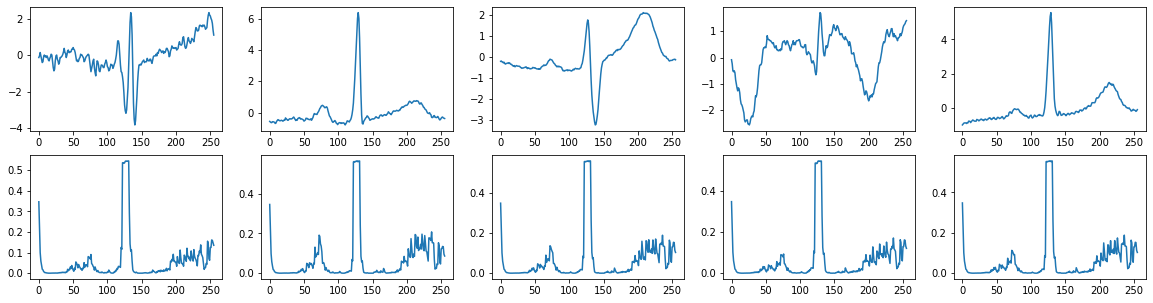

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

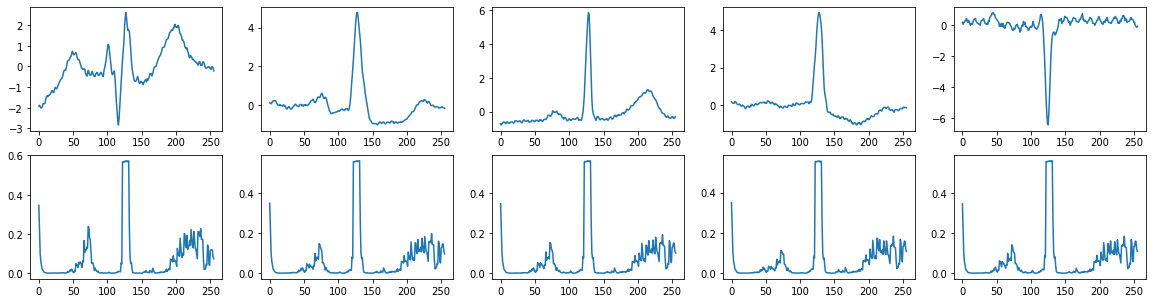

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

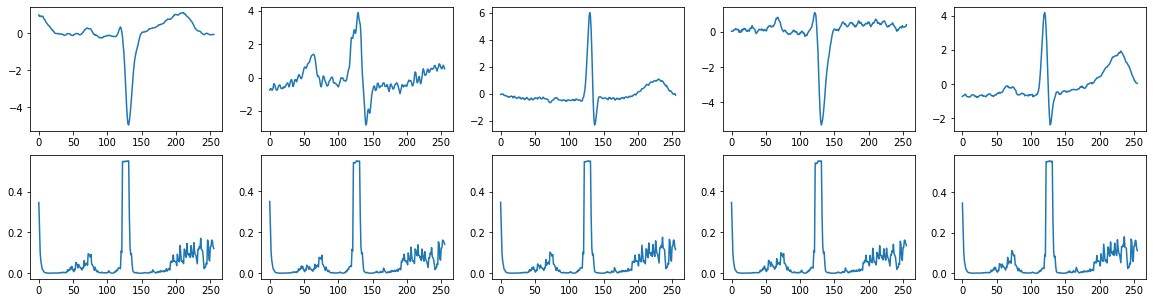

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

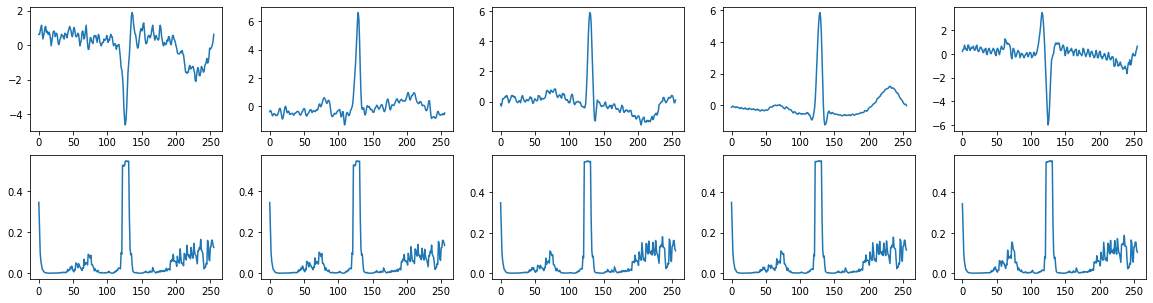

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

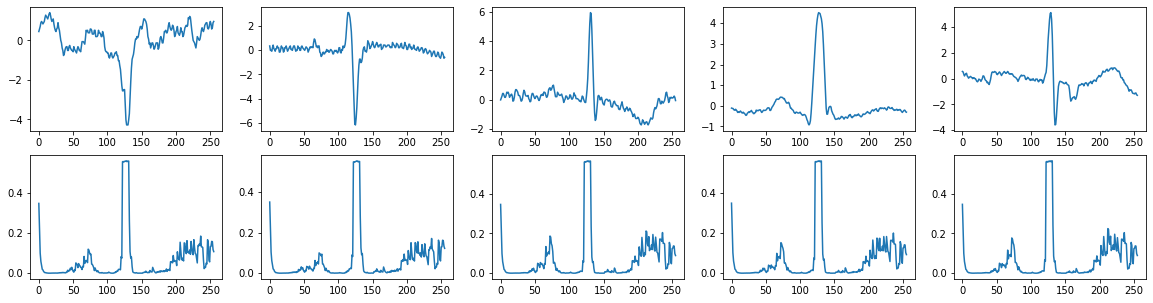

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

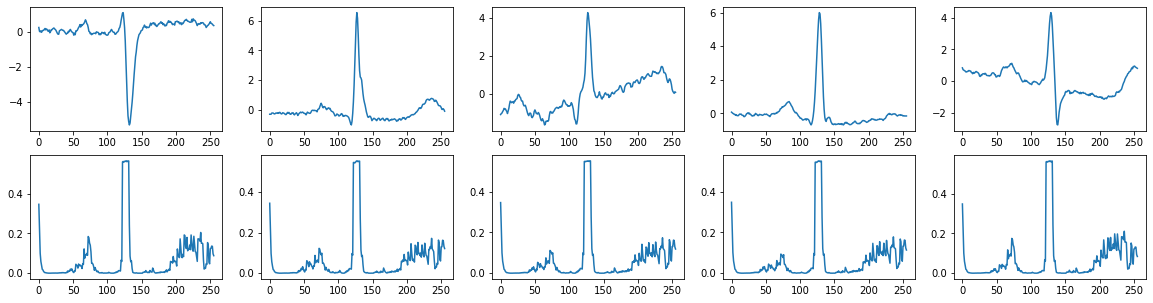

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

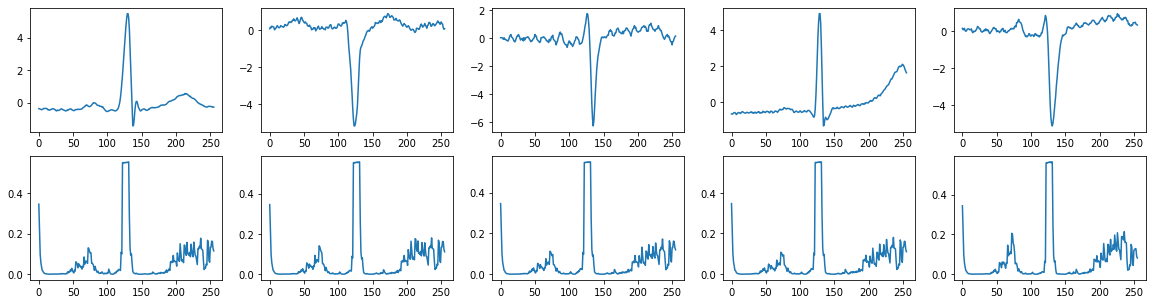

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

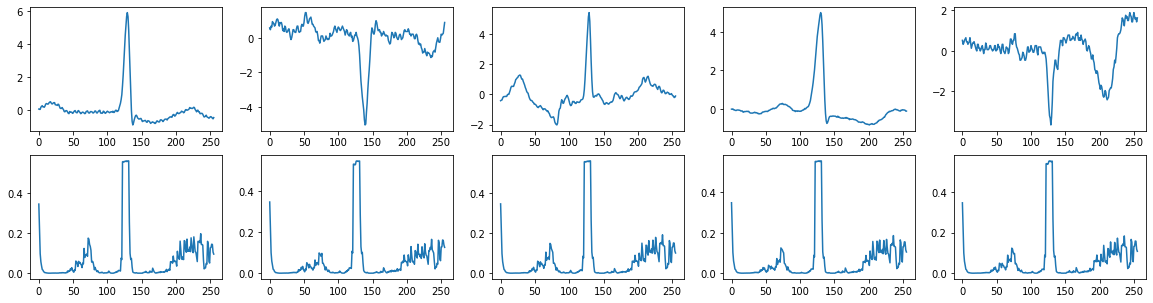

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

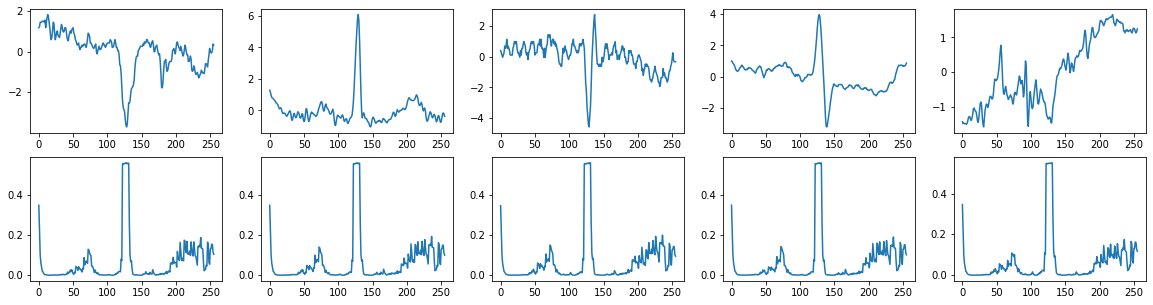

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

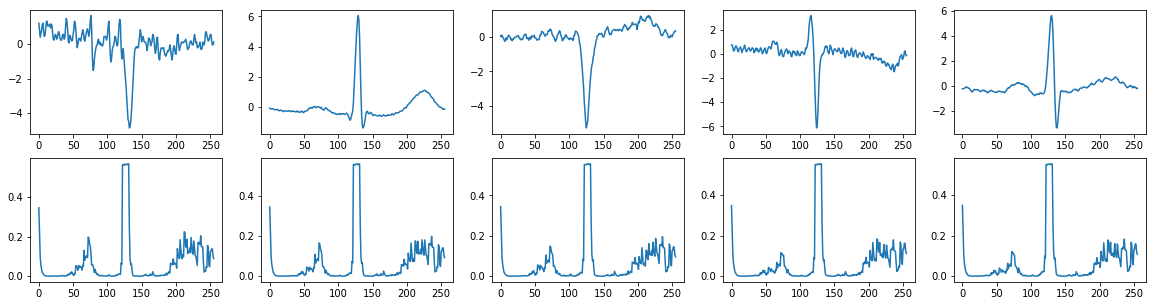

Streaming output truncated to the last 5000 lines.
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])
conv after view torch.Size([64, 19])
mu torch.Size([64, 10])
logvar torch.Size([64, 10])
z torch.Size([64, 10])
deconv torch.Size([64, 19])
after view torch.Size([64, 1, 19])
>>>>>> torch.Size([64, 256])
forward torch.Size([64, 1, 256])
encode torch.Size([64, 1, 256])
after permute torch.Size([64, 1, 256])
conv torch.Size([64, 1, 19])

In [173]:
for epoch in range(10):
    test(epoch)


In [ ]:
# sample from latent space
with torch.no_grad():
    sample = torch.randn(64, ZDIMS).to(device)
    print(sample.shape)
    sample = model.decode(sample).cpu()
    # sample = sample.permute(0,2,1)
    print(sample.shape)
    f, a = plt.subplots(1, 2, figsize=(20,5))
    view_data = sample[:5].view(-1, 256).type(torch.FloatTensor)

    for i in range(2):
        a[i].plot(view_data.cpu().data.numpy()[i])

    # for i in range(5):
    #     a[1][i].clear()
    #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
    plt.show();

In [ ]:
check = torch.randn(64,256,1)
# check = check[0]
check = check.permute(1,0,2)
print(check.shape)

In [ ]:
c = torch.randn(64,256,1)
print(check[0].shape)

In [ ]:
x = torch.randn(125,64)
x = torch.unsqueeze(x,2)
print(x.shape)